In [1]:
import numpy as np
import math
import time
import random
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from odeintw import odeintw
from scipy.integrate import odeint
from scipy import stats
from scipy.stats import norm
from scipy.stats import truncnorm
sns.set_style('darkgrid')
paleta = sns.color_palette("Paired")
paleta

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

### Cargo Datos:

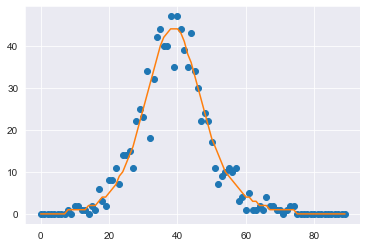

In [2]:
#cargo datos sin ruido
txt = np.loadtxt('datos_inci.txt', skiprows = 0) 
txt_round = np.round(txt)
#Agrego Ruido (con la misma semilla) para obtener mis datos
np.random.seed(123)
data = scipy.stats.poisson.rvs(txt_round)
#Grafico
plt.plot(data,'o')
plt.plot(txt_round)

### Modelo SEnIR Coxiano

Este depende del valor de $n$ para determinar el número de subcompartimentos de los Expuestos, si $n>1$ se plantea de manera matricial y si $n=1$ se hace ecuación por ecuación.

Sus argumentos son:
1. X: Condiciones iniciales
2. t: Periodo de 90 días
3. theta: Vector de parámetros, también depende del valor de $n$:
$$
\theta = (\beta, \gamma, (\lambda_{1},\dots,\lambda_{n}),[p_{1},p_{2},\dots,p_{n-1}),n)
$$

##### OJO: Aquí se supone que $\lambda_{1} = \lambda_{2} = \dots = \lambda_{n}$ por lo que el ejercicio de inferencia se hace para un solo valor y se aplica un np.repeat para vectorizar cuando entra al modelo

In [4]:
def SEnIR_Cox(X,t,theta):
    n = theta[4]
    if(n>1):
        diag0 = np.append(theta[0], theta[2]*(1-np.append(theta[3],1)))
        diag1 = -theta[2]
        tt = np.diag(diag0)+np.diag(diag1,1)
        tt = np.delete(tt, n, axis=0)
        a = X[0]*X[n+1]/N 
        XX = np.append(a,X[1:n+1])
        dS = -theta[0]*a
        dE = tt@XX
        dI = np.sum(theta[2]*np.append(theta[3],1)*X[1:n+1])-theta[1]*X[n+1]  
        dY = np.sum(theta[2]*np.append(theta[3],1)*X[1:n+1])
        dR = theta[1]*X[n+1]
        sols = np.append(dS,dE)
        sols = np.array(np.append(sols,[dI,dY,dR]))
    else: 
        theta =[theta[0],theta[1],theta[2][0],theta[3],theta[4]]
        dS = -theta[0]*X[0]*X[2]/N
        dE = theta[0]*X[0]*X[2]/N - theta[2]*X[1]
        dI = theta[2]*X[1] - (theta[1]*X[2])
        dY = theta[2]*X[1]
        dR = theta[1]*X[2]
        sols = np.array([dS,dE,dI,dY,dR])
        sols = sols.reshape(5,)
    return(sols)

### Preparo funciones para la inferencia:
1. D. A priori:
$$ \beta, \gamma,\lambda \sim \text{Gamma}(1,0.6) \quad p_{j} \sim \text{Beta}(10,1) \quad n\sim \text{U}(1,5) \quad j = 1,2,\dots , n-1$$

Se suponen todos los parámetros independientes. El argumento de la función es el vector de parámetros $\theta$.

In [5]:
## Hiperparámetros

b_hiper = [1,0.6]  
g_hiper = [1,0.6]  
l_hiper = [1,0.6]  
p_hiper = [10,1]   
M = 5
def aprioris(theta):
    db = scipy.stats.gamma.pdf(theta[0],b_hiper[0],0,b_hiper[1])
    dg = scipy.stats.gamma.pdf(theta[1],g_hiper[0],0,g_hiper[1])
    dl = scipy.stats.gamma.pdf(theta[2][0],l_hiper[0],0,l_hiper[1])
    dn = 1/M
    if theta[4]>1:
        dpv = scipy.stats.beta.pdf(theta[3],p_hiper[0],p_hiper[1])
        return(db*dg*dl*np.prod(dpv)*dn)
    else:
        return(db*dg*dl*dn)

2. Verosimilitud:


In [6]:
def verosimilitud(theta, X0):
    n = theta[4]
    N = 1000
    dias = 90
    t = np.linspace(0,dias,dias+1)
    Xt = odeintw(SEnIR_Cox, X0, t, args=(theta,))   
    ### Incidencia
    Inct = np.diff(Xt[:,n+2])  #diferencias del estado Y
    ## empieza Poisson
    ver = np.empty(len(data))
    for i in range(0,len(data)):
        ver[i] = scipy.stats.poisson.pmf(data[i],mu=Inct[i])
    prod = np.prod(ver)
    return(prod)

In [7]:
### F(\theta|y) = L(y|\theta)f(\theta)
def posterior(theta,X0):
    n=round(theta[4])
    lamb = theta[2][0]
    if theta[0]<0 or theta[1]<0 or theta[2][0]<0 or n>M or np.any(theta[3]<0) or np.any(theta[3]>1):
        return(0)
    else:
        ver = verosimilitud(theta,X0)
    return(aprioris(theta)*ver)

In [10]:
##### Kernels de Trans.

## para los parámetros que tienen dist Gamma
def rker1(param,ss):
    myclip_a = 0
    myclip_b = 10000000000
    my_mean = param
    my_std = ss
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    tempo = truncnorm.rvs(a,b,loc = my_mean, scale = my_std, size=1)[0]
    return(tempo)
    

## para los param que tienen dist beta
def rker2(param,ss):
    myclip_a = 0
    myclip_b = 1
    my_mean = param
    my_std = ss
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    tempo = truncnorm.rvs(a,b,loc = my_mean, scale = my_std, size=1)[0]
    return(tempo)


## para param n
def rker_n(param, maxval=5):
    prop_n = scipy.stats.randint.rvs(max(param-1,1),min(param+2,maxval+1),size=1)[0]
    return(prop_n)

In [11]:
def dker1(x,mean,ss):
    myclip_a = 0
    myclip_b = 10000000000
    my_mean = mean
    my_std = ss
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    den = truncnorm.pdf(x, a, b, loc = my_mean, scale = my_std)
    return(den)
    
def dker2(x,mean, ss):
    myclip_a = 0
    myclip_b = 1
    my_mean = mean
    my_std = ss
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    den = truncnorm.pdf(x, a, b, loc = my_mean, scale = my_std)
    return(den)

def dker_n(x,actual,maxval=5): 
    den = x/maxval
    return(den)

   
def dmulti_kers(vect1,vect2,ss): ##vect2 = actual, vect1 = prop
    prod_kers = 1.
    prod_kers = prod_kers * dker1(vect1[0],mean=vect2[0],s1=ss) * dker1(vect1[1],mean=vect2[1],s1=ss)
    prod_kers = prod_kers * dker1(vect1[2][0],mean=vect2[2][0],s1=ss)
    nval=min(vect1[4],vect2[4]) 
    for k in range(0,nval-1):
        prod_kers = prod_kers * dker2(vect1[3][k], mean = vect2[3][k], s1=ss)
    return(prod_kers)

### Empieza MCMC

ojo: Tiene restricción para movimientos (cambios entre espacios parametrales --> cambios de modelo) de nacimiento/muerte/permanencia

In [12]:
def rjmcmc(iters, alpha, s1, s2, theta_ini,X0):
    
    # donde guardaré las cadenas
    b = np.zeros(iters)
    g = np.zeros(iters)
    ele = np.zeros(iters)   
    pes = np.zeros((iters,M-1))   
    enes = np.zeros(iters)
    poster = np.empty(iters)   
  
    # primer elemento de la cadena: valores de theta_ini
    b[0] = theta_ini[0]
    g[0] = theta_ini[1]
    ele[0] = theta_ini[2][0] 
    pes[0,0:len(theta_ini[3])] = theta_ini[3] 
    enes[0] = theta_ini[4]
    
    theta_act = theta_ini.copy()
    X0act = X0.copy()
    poster[0] = posterior(theta_act,X0act)
    
    actualizo = 1
    
    for i in range(1,iters):
        ### para no desesperarme
        if i%10000 == 0:
            print('------ ITER -----: ',i)
        
        if np.random.uniform(0,1,1) < alpha:   # escoge varianza para los tamanos de paso (dos propuestas que entran como argumento)
            ss = s1
        else:
            ss = s2
            
        # Generamos propuesta  de n con posiblemente diferente dimensión 
        nprop = rker_n(theta_act[4],maxval=M)   ##puede salir el actual, uno más o uno menos
        
        # Generamos propuesta de b, g y l (la de l cambiará después si es que en esta iteracion n es la misma que la iter anterior)
        bprop = rker1(theta_act[0],ss)
        gprop = rker1(theta_act[1],ss)
        lprop = rker1(theta_act[2][0],ss)
        
        # pprop primero se basa en la dimensión actual, no la propuesta. (Sirve para cuando no se modifica la dim)
        # si cae between-m. se modifica dependiendo de birth/death
        
        if theta_act[4]>1:
            pprop = np.zeros(theta_act[4]-1)
            for k in range(0,theta_act[4]-1):
                pprop[k] = rker2(theta_act[3][k],ss)
                
        else:
            pprop = np.array([])
                                 
        
        ####################### NOS MOVEMOS EN LA MISMA DIMENSIÓN ########################
        
        ## funciona como un MH usual
        
        if nprop == theta_act[4]:
                
            #creamos el vector propuesta
            theta_prop = [bprop, gprop, np.repeat(lprop,nprop), pprop, nprop]
                    
            qxy = dmulti_kers(theta_act,theta_prop,ss)# centrada en propuesto
            qyx = dmulti_kers(theta_prop,theta_act,ss)# centrada en actual
            num = posterior(theta_prop,X0act)*qxy  # Se usa la misma X0 en ambas partes
            den = posterior(theta_act,X0act)*qyx
            razon = num / den
            
            #aceptación
            A = min(1,razon)

            if np.random.uniform(0,1,1) < A:             #actualiza
                theta_act = theta_prop.copy()
                b[i] = theta_prop[0]
                g[i] = theta_prop[1]
                ele[i] = theta_prop[2][0]
                enes[i] = nprop
                pes[i,0:len(theta_prop[3])] = theta_prop[3]
                poster[i] = posterior(theta_prop, X0act)
                actualizo=actualizo+1
            else:                                         #quédate donde estás
                b[i] = b[i-1]
                g[i] = g[i-1]
                ele[i] = ele[i-1]
                pes[i,:] = pes[i-1,:]
                poster[i] = poster[i-1]
                enes[i] = enes[i-1]  

                    
        ####################### NOS MOVEMOS A DIFERENTE DIMENSIÓN ########################          
                       
        else:  
            
            X0prop = X0act.copy()
            
            ################## Nacimiento #################
            ## va a una dimensión mayor
            ## entonces, se propone una nueva lambda y la p faltante
                
            if nprop > theta_act[4]:
                
                X0prop.insert(nprop+1, 0)
                
                # para las propuestas:
                u = np.random.uniform(0,1,1)[0]
                alfa_nmenos1 = np.sum(np.cumprod(np.append(1,pprop)))
                c = (np.prod(pprop)/alfa_nmenos1)*u+1

                lstar = c*lprop
                p_nueva =(c-1)*alfa_nmenos1/np.prod(pprop)
                
                ## se crea vector
                theta_prop = [bprop, gprop, np.repeat(lstar,nprop),np.append(pprop,p_nueva), nprop]
                
                qxy = dmulti_kers(theta_act,theta_prop,ss)*dker_n(theta_act[4],theta_prop[4],maxval=M) # centrada en propuesto
                qyx = dmulti_kers(theta_prop,theta_act,ss)*dker_n(theta_prop[4],theta_act[4],maxval=M) # centrada en actual
                num = posterior(theta_prop, X0prop)*qxy
                den = posterior(theta_act, X0act)*qyx
                Jac = c
                razon = num / den *Jac
                
                #aceptación
                A = min(1,razon)

                if np.random.uniform(0,1,1) < A:           # actualiza
                    theta_act = theta_prop.copy()
                    X0act = X0prop.copy()
                    b[i] = theta_prop[0]
                    g[i] = theta_prop[1]
                    ele[i] = theta_prop[2][0]   
                    pes[i,0:len(theta_prop[3])] = theta_prop[3]
                    enes[i] = nprop
                    poster[i] = posterior(theta_prop, X0prop)
                    actualizo = actualizo+1
                else:                                     # quédate donde estás
                    b[i] = b[i-1]
                    g[i] = g[i-1]
                    ele[i] = ele[i-1]
                    pes[i,:] = pes[i-1,:]
                    poster[i] = poster[i-1]
                    enes[i] =  enes[i-1]

            ############### Muerte ##########################
            ## baja una dimensión
            ## se propone nueva lambda y se quita un p
            
            else: 
                
                X0prop.pop(theta_act[4])
                
                #para hacer propuesta
                alfa_nmenos1 = np.sum(np.cumprod(np.append(1,pprop)))
                alfa_nmenos2 = np.sum(np.cumprod(np.append(1,pprop[:-1])))
                c = (np.prod(pprop[0:nprop-1])/alfa_nmenos2)*pprop[-1]+1
                
                lstar = lprop*alfa_nmenos2/alfa_nmenos1
                
                #se crea vector
                theta_prop = [bprop, gprop, np.repeat(lstar,nprop), pprop[:-1], nprop]
                
                qxy = dmulti_kers(theta_act,theta_prop,ss)*dker_n(theta_act[4],theta_prop[4],maxval=M)# centrada en propuesto
                qyx = dmulti_kers(theta_prop,theta_act,ss)*dker_n(theta_prop[4],theta_act[4],maxval=M)# centrada en actual
                num = posterior(theta_prop, X0prop)*qxy
                den = posterior(theta_act, X0act)*qyx
                Jac = 1/c 
                
                #aceptación
                razon = num / den * Jac
                A = min(1,razon)
                
                if np.random.uniform(0,1,1) < A:        # actualiza
                    theta_act = theta_prop.copy()
                    X0act = X0prop.copy()
                    b[i] = theta_prop[0]
                    g[i] = theta_prop[1]
                    ele[i] = theta_prop[2][0]   
                    pes[i,0:len(theta_prop[3])] = theta_prop[3]
                    poster[i] = posterior(theta_prop, X0prop)
                    enes[i] = theta_prop[4]
                    actualizo = actualizo+1
                else:                                 # quédate donde estás
                    b[i] = b[i-1]
                    g[i] = g[i-1]
                    ele[i] = ele[i-1]
                    pes[i,:] = pes[i-1,:]
                    poster[i] = poster[i-1]
                    enes[i] =  enes[i-1]
     
    #cuántas veces actualizo y rechazó?
    rechazo = iters-actualizo
    return(b,g,ele,pes,enes, rechazo,actualizo,poster)

In [13]:
#### Valores y condiciones iniciales
n = 3
b = scipy.stats.gamma.rvs(1,0,0.6,size = 1)[0]
g = scipy.stats.gamma.rvs(1,0,0.6,size = 1)[0]
l = scipy.stats.gamma.rvs(1,0,0.6,size = 1)[0]
lv = np.repeat(l, n)
pv = scipy.stats.beta.rvs(10,1,size = n-1)

theta_ini = [b,g,lv,pv,n]

M = 5 #Cota superior de la traza de n
N = 1000. #Tamano de la población

S0 = N-1.
E0 = [0] * n 
E0[0] = 1.
I0 = 0.
Y0 = 1.
R0 = 0.
X0 = [S0]+E0+[I0,Y0,R0] #condiciones iniciales
X0

[999.0, 1.0, 0, 0, 0.0, 1.0, 0.0]

In [14]:
#######################
### Corre el modelo ###
#######################

iters = 200000
alpha = 0.5
s1 = 0.004
s2 = 0.04
np.random.seed(123)
b,g,ele,pes,enes,rechazo,actualizo,poster = rjmcmc(iters,alpha,s1,s2,theta_ini,X0)

In [12]:
print('Actualizó: ', actualizo)
print('Rechazó: ', rechazo)

Actualizó:  51736
Rechazó:  148264


In [15]:
### para guardar las cadenas
#np.savetxt('Cadena_b_datos1_conruido_rjmcmc.txt',b,fmt =' %.15e', delimiter=' ')

In [28]:
#### Cadenas de cada parámetro:
burn_in = 

b_bi = b[bi:]
g_bi = g[bi:]
l_bi = ele[bi:]
n_bi = enes[bi:]

poster_bi = poster[bi:]

p1 = pes[bi:,0]
p2 = pes[bi:,1]
p3 = pes[bi:,2]
p4 = pes[bi:,3]